In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mode

2022-10-06 16:21:36.496406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [429]:
# Read in file 
data = pd.read_csv("../data/curated/outliers_removed.csv")

In [430]:
# Change Weekly Rental Price columns to first column
price = data["Weekly Rental Price"]
data = data.drop(["Weekly Rental Price"], axis = 1)
data.insert(0, "Weekly Rental Price", price)

In [431]:
data = data.drop(labels = ['Unnamed: 0'],axis = 1) 

In [432]:
data = data.fillna(40000)
#data = data[data["Income"] != "np"]
data = data[(data['Baths'] > 0) & (data['Bedrooms'] > 0)]

In [433]:
data

,Weekly Rental Price,Postcode,Baths,Bedrooms,Parking,Count_Shopping_Center,Income
0,440.0,3000,1,1,1,18.0,38674.046186
1,650.0,3000,2,2,1,18.0,38674.046186
2,440.0,3000,1,1,0,18.0,38674.046186
3,320.0,3000,1,1,0,18.0,38674.046186
4,700.0,3000,2,2,0,18.0,38674.046186
...,...,...,...,...,...,...,...
11491,600.0,3996,2,3,2,0.0,52284.246429
11492,550.0,3996,2,4,0,0.0,52284.246429
11493,420.0,3996,1,2,0,0.0,52284.246429
11494,370.0,3996,1,2,1,0.0,52284.246429


In [434]:
# Take out postcode column
postcode = data["Postcode"]

In [435]:
# Apply one hot encoding on Postcode
new_data = pd.get_dummies(data, columns = ['Postcode'])

In [436]:
# Split features and predict results
y = new_data['Weekly Rental Price']
x = new_data.iloc[:,1:]

In [437]:
# Processed X into value between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(x)

In [438]:
# Split the data set into training/testing and validation sets
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [439]:
# Create model and train the model
model = Sequential([
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1), input_shape=(426,)),
    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)),
    Dense(1, activation='linear', kernel_regularizer = regularizers.l2(0.1))])

model.compile(optimizer = "adam",
              loss='mean_squared_logarithmic_error',
              metrics=['msle'])

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
252/252 [==============================] - 4s 8ms/step - loss: 25.5232 - msle: 21.7352 - val_loss: 14.7038 - val_msle: 11.3715
Epoch 2/100
252/252 [==============================] - 1s 5ms/step - loss: 12.1101 - msle: 8.6374 - val_loss: 10.3074 - val_msle: 6.7512
Epoch 3/100
252/252 [==============================] - 1s 5ms/step - loss: 9.2824 - msle: 5.6716 - val_loss: 8.4663 - val_msle: 4.8063
Epoch 4/100
252/252 [==============================] - 1s 5ms/step - loss: 7.9679 - msle: 4.3013 - val_loss: 7.5620 - val_msle: 3.8879
Epoch 5/100
252/252 [==============================] - 1s 4ms/step - loss: 7.2805 - msle: 3.6270 - val_loss: 7.0301 - val_msle: 3.4036
Epoch 6/100
252/252 [==============================] - 1s 4ms/step - loss: 6.8289 - msle: 3.2461 - val_loss: 6.6360 - val_msle: 3.0955
Epoch 7/100
252/252 [==============================] - 1s 6ms/step - loss: 6.4671 - msle: 2.9964 - val_loss: 6.2982 - val_msle: 2.9006
Epoch 8/100
252/252 [============================

54/54 [==============================] - 0s 3ms/step - loss: 0.8217 - msle: 0.3146


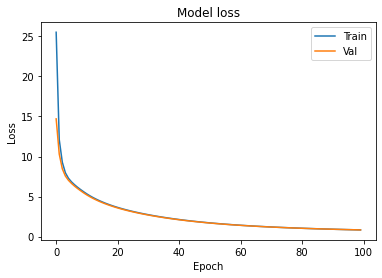

In [443]:
# Do the model evaluation
model.evaluate(X_test, Y_test)[1]

# Plot the model performance
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

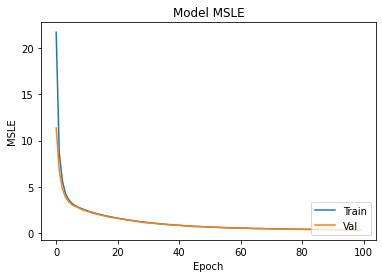

In [444]:
plt.plot(hist.history['msle'])
plt.plot(hist.history['val_msle'])
plt.title('Model MSLE')
plt.ylabel('MSLE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [445]:
# Predict the va;idation set
prediction = model.predict(X_val)

# Calculate the absolute errors
error = prediction - Y_val[0]
error = [abs(x) for x in error]

# Print out the mean absolute error (mae)
np.mean(error)

54/54 [==============================] - 0s 2ms/step


KeyError: 0

In [ ]:
# calculate the absolute errors of baseline model
y_mode = mode(Y_val)
baseline_error = [abs(y_mode - x) for x in Y_val]
np.mean(baseline_error)

In [446]:
post_data = new_data.iloc[:,1:]
post_data.insert(0, "Postcode", postcode)

In [447]:
pop = pd.read_csv("../data/curated/predict_income.csv")

In [448]:
# Update population in 2023/2024/2025
pop = pd.read_csv("../data/curated/predict_income.csv")
pop_2023 = pop[['Postcode','2023']]
pop_2024 = pop[['Postcode','2024']]
pop_2025 = pop[['Postcode','2025']]

In [449]:
pop_2023 = pd.merge(pop_2023, post_data, how = 'right', on = ['Postcode'])
pop_2023

,Postcode,2023,Baths,Bedrooms,Parking,Count_Shopping_Center,Income,Postcode_3000,Postcode_3002,Postcode_3003,...,Postcode_3976,Postcode_3977,Postcode_3978,Postcode_3980,Postcode_3981,Postcode_3984,Postcode_3987,Postcode_3992,Postcode_3995,Postcode_3996
0,3000,40143.738881,1,1,1,18.0,38674.046186,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3000,40143.738881,2,2,1,18.0,38674.046186,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3000,40143.738881,1,1,0,18.0,38674.046186,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3000,40143.738881,1,1,0,18.0,38674.046186,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000,40143.738881,2,2,0,18.0,38674.046186,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11491,3996,54359.444697,2,3,2,0.0,52284.246429,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11492,3996,54359.444697,2,4,0,0.0,52284.246429,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11493,3996,54359.444697,1,2,0,0.0,52284.246429,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11494,3996,54359.444697,1,2,1,0.0,52284.246429,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [450]:
pop_2023 = pop_2023.drop(labels = ['Income'],axis = 1) 
pop_2023 = pop_2023.iloc[:,1:]
income_2023 = pop_2023["2023"]
pop_2023 = pop_2023.drop(labels = ['2023'],axis = 1) 
pop_2023.insert(4, 'Income', income_2023)
pop_2023

,Baths,Bedrooms,Parking,Count_Shopping_Center,Income,Postcode_3000,Postcode_3002,Postcode_3003,Postcode_3004,Postcode_3006,...,Postcode_3976,Postcode_3977,Postcode_3978,Postcode_3980,Postcode_3981,Postcode_3984,Postcode_3987,Postcode_3992,Postcode_3995,Postcode_3996
0,1,1,1,18.0,40143.738881,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,1,18.0,40143.738881,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,18.0,40143.738881,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,18.0,40143.738881,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,0,18.0,40143.738881,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11491,2,3,2,0.0,54359.444697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11492,2,4,0,0.0,54359.444697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11493,1,2,0,0.0,54359.444697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11494,1,2,1,0.0,54359.444697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [451]:
pred_2023 = model.predict(pop_2023)
data.insert(7, 'Pred_2023', pred_2023)
data

360/360 [==============================] - 1s 2ms/step


,Weekly Rental Price,Postcode,Baths,Bedrooms,Parking,Count_Shopping_Center,Income,Pred_2023
0,440.0,3000,1,1,1,18.0,38674.046186,1917.296143
1,650.0,3000,2,2,1,18.0,38674.046186,1917.311401
2,440.0,3000,1,1,0,18.0,38674.046186,1917.292358
3,320.0,3000,1,1,0,18.0,38674.046186,1917.292358
4,700.0,3000,2,2,0,18.0,38674.046186,1917.307739
...,...,...,...,...,...,...,...,...
11491,600.0,3996,2,3,2,0.0,52284.246429,2473.145752
11492,550.0,3996,2,4,0,0.0,52284.246429,2473.146973
11493,420.0,3996,1,2,0,0.0,52284.246429,2473.123047
11494,370.0,3996,1,2,1,0.0,52284.246429,2473.126709


In [211]:


pop_2023['Count_School'] = pop_2023['Count_School'].fillna(value = 0)
pop_2023['Count_Station'] = pop_2023['Count_Station'].fillna(value = 0)
pop_2023 = pop_2023.dropna(axis = 0)
pop_2023 = pop_2023[(pop_2023['Baths'] > 0) & (pop_2023['Bedrooms'] > 0)]
pred_2023 = model.predict(pop_2023)
data.insert(7, 'Pred_2023', pred_2023)

pop_2024 = pd.merge(pop_2024, post_data, how = 'inner', on = ['Postcode'])
pop_2024 =pop_2024.drop(labels = ['Income'],axis = 1) 
pop_2024 = pop_2024.iloc[:,1:]

pop_2024['Count_School'] = pop_2024['Count_School'].fillna(value = 0)
pop_2024['Count_Station'] = pop_2024['Count_Station'].fillna(value = 0)
pop_2024 = pop_2024.dropna(axis=0)
pop_2024 = pop_2024[(pop_2024['Baths'] > 0) & (pop_2024['Bedrooms'] > 0)]
pred_2024 = model.predict(pop_2024)
data.insert(8, 'Pred_2024', pred_2024)

pop_2025 = pd.merge(pop_2025, post_data, how='inner', on=['Postcode'])
pop_2025 =pop_2025.drop(labels=['Population'], axis=1) 
pop_2025 = pop_2025.iloc[:,1:]

pop_2025['Count_School'] = pop_2025['Count_School'].fillna(value = 0)
pop_2025['Count_Station'] = pop_2025['Count_Station'].fillna(value = 0)
pop_2025 = pop_2025.dropna(axis=0)
pop_2025 = pop_2025[(pop_2025['Baths'] > 0) & (pop_2025['Bedrooms'] > 0)]
pred_2025 = model.predict(pop_2025)
data.insert(9, 'Pred_2025', pred_2025)

KeyError: "['Population'] not found in axis"

In [145]:
# Calculate growth rate
data['rate_2023'] = (data['Pred_2023'] - data['Weekly Rental Price']) / data['Weekly Rental Price']
data['rate_2024'] = (data['Pred_2024'] - data['Weekly Rental Price']) / data['Weekly Rental Price']
data['rate_2025'] = (data['Pred_2025'] - data['Weekly Rental Price']) / data['Weekly Rental Price']
data = data[["Postcode", "Weekly Rental Price", "Pred_2023", "Pred_2024", "Pred_2025", "rate_2023", "rate_2024", "rate_2025"]]


In [146]:
# Group by the data by the postcode
data = data.groupby(by = ['Postcode']).mean()
data = data.sort_values(by = ['rate_2023'], ascending = False)
data = data.head(10)
data.to_csv("../data/curated/NNpredi.csv")

In [ ]:
data